In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opc
import MDAnalysis as mda
import os

In [30]:
class OrderParameters:
    def __init__(self, u, atomlists, resname, selection, start_frame=0):        
        self.u = u
        self.atomlists = atomlists
        self.resname = resname
        self.selection = selection
        self.start_frame = start_frame
        
        self.C_numbers, self.Cs, self.Hs_f, self.repeat = self.process_atom_lists()

    def process_atom_lists(self):
        C_numbers = []
        Cs = []
        Hs = []
        repeat = []
        
        for atoms in self.atomlists:
            C_number = atoms[0][2:]
            C_numbers.append(int(C_number))
            Cs.append(atoms[0])
            Hs.append(atoms[1:])
            repeat.append(len(atoms) - 1)
        
        Hs_f = [item for sublist in Hs for item in sublist]
        
        assert int(np.sum(repeat)) == len(Hs_f), "Mismatch in repeats"
        return C_numbers, Cs, Hs_f, repeat

    def compute_OP(self):
        print("Selection string:", self.selection)
        print("Universe object:", self.u)

        all_molecules = self.u.select_atoms(self.selection, updating=True)
        print(all_molecules)
        output = []
        total_frames = len(self.u.trajectory)

        for idx, ts in enumerate(self.u.trajectory[self.start_frame:]):
            print(f"Processing frame {idx + 1} of {total_frames} ...")
            valid_indices_group1 = []
            valid_indices_group2 = []

            for molecule in all_molecules.residues:
                atoms_in_molecule = molecule.atoms
                if all(atom.index in all_molecules.indices for atom in atoms_in_molecule):
                    valid_indices_group1.extend(molecule.atoms.select_atoms("name " + " ".join(self.Cs)).indices)
                    valid_indices_group2.extend(molecule.atoms.select_atoms("name " + " ".join(self.Hs_f)).indices)

            group1 = self.u.atoms[valid_indices_group1]
            group2 = self.u.atoms[valid_indices_group2]

            natoms = len(self.Cs)
            nmols = int(len(group1.positions) / natoms)
            repeats = self.repeat * nmols

            p1 = np.repeat(group1.positions, repeats, axis=0)
            p2 = group2.positions
            dp = p2 - p1
            norm = np.sqrt(np.sum(np.power(dp, 2), axis=-1))
            cos_theta = dp[..., 2] / norm

            S = -0.5 * (3 * np.square(cos_theta) - 1)

            new_S = self._average_over_hydrogens(S, repeats)
            new_S.shape = (nmols, natoms)
            results = np.average(new_S, axis=0)
            # print(results)
            output.append(results)

        avg = np.average(output, axis=0)
        return np.transpose([self.C_numbers, avg])

    def _average_over_hydrogens(self, x, reps):
        assert len(x) == int(np.sum(reps)), 'Mismatch in repeats'
        i = 0
        out = []
        for rep in reps:
            tmp = []
            for r in range(rep):
                tmp.append(x[i])
                i += 1
            out.append(np.average(tmp))
        return np.array(out)


In [31]:

def run_op(TOP,TRAJ, output_folder_name,  lipid_info, start_frame, name, use_ranges=False, ranges=None):
    u = mda.Universe(TOP,TRAJ)
    output_folder = output_folder_name
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    leaflets = ["bottom", "top"]
    halfz = u.dimensions[2] / 2
    has_protein = len(u.select_atoms("protein")) > 0
    for leaflet in leaflets:
        print(f"\nProcessing {leaflet} leaflet ...")
        if leaflet == "bottom":
            z_condition = f"prop z < {halfz}"
        else:  # top leaflet
            z_condition = f"prop z > {halfz}"
        use_ranges = False  # Set this variable to True or False based on your requirement

        if use_ranges and ranges:
            for start, end, lable in ranges:

                for lipid, atomlist in lipd_info.items():
                    if has_protein:
                        if end:
                            selection = f"resname {lipid} and (around {end} protein) and not (around {start} protein) and {z_condition}"
                        else:
                            selection = f"resname {lipid} and not (around {start} protein) and {z_condition}"
                    else:
                        selection = f"resname {lipid} and {z_condition}"
                OP = OrderParameters(u, atomlist, lipid, selection, start_frame)
                print("OrderParameters object created.")
                results = OP.compute_OP()
                print("Order parameter computed.")
                output_path = os.path.join(output_fold, f"{name}_{leaflet}_{label}nm.dat") if has_protein and end else os.path.join(output_folder, f"{name}_{leaflet}_control.dat")


        else:
            for lipid, atomlist in lipid_info.items():
                selection = f"resname {lipid} and {z_condition}"
                print(f"Using selection: {selection}")
                OP = OrderParameters(u, atomlist, lipid, selection, start_frame)
                print(f"OrderParameters object for {lipid} created.")
                results = OP.compute_OP()
                print("Order parameter computed.")
                
                output_path = os.path.join(output_folder, f"{name}_{leaflet}.dat")
                np.savetxt(output_path, results)
                print(f"Saved to {output_path}\n")


In [41]:
lipid_info = {'DOPE': opc.DOPE2}
run_op('trajs/gro.gro', 'trajs/c36_skip100.xtc', "c36", lipid_info, start_frame=80, name='DOPE2')


Processing bottom leaflet ...
Using selection: resname DOPE and prop z < 101.5615463256836
OrderParameters object for DOPE created.
Selection string: resname DOPE and prop z < 101.5615463256836
Universe object: <Universe with 137711 atoms>
<AtomGroup [<Atom 96225: N of type N of resname DOPE, resid 623 and segid SYSTEM>, <Atom 96226: HN1 of type H of resname DOPE, resid 623 and segid SYSTEM>, <Atom 96227: HN2 of type H of resname DOPE, resid 623 and segid SYSTEM>, ..., <Atom 102027: H18X of type H of resname DOPE, resid 667 and segid SYSTEM>, <Atom 102028: H18Y of type H of resname DOPE, resid 667 and segid SYSTEM>, <Atom 102029: H18Z of type H of resname DOPE, resid 667 and segid SYSTEM>]>
Processing frame 1 of 109 ...
Processing frame 2 of 109 ...
Processing frame 3 of 109 ...
Processing frame 4 of 109 ...
Processing frame 5 of 109 ...
Processing frame 6 of 109 ...
Processing frame 7 of 109 ...
Processing frame 8 of 109 ...
Processing frame 9 of 109 ...
Processing frame 10 of 109 ..

In [42]:
lipid_info = {'DOPE': opc.DOPE2}
run_op('trajs/gro.gro', 'trajs/c36c_skip100.xtc', "c36c", lipid_info, start_frame=80, name='DOPE2')


Processing bottom leaflet ...
Using selection: resname DOPE and prop z < 101.5615463256836
OrderParameters object for DOPE created.
Selection string: resname DOPE and prop z < 101.5615463256836
Universe object: <Universe with 137711 atoms>
<AtomGroup [<Atom 96225: N of type N of resname DOPE, resid 623 and segid SYSTEM>, <Atom 96226: HN1 of type H of resname DOPE, resid 623 and segid SYSTEM>, <Atom 96227: HN2 of type H of resname DOPE, resid 623 and segid SYSTEM>, ..., <Atom 102027: H18X of type H of resname DOPE, resid 667 and segid SYSTEM>, <Atom 102028: H18Y of type H of resname DOPE, resid 667 and segid SYSTEM>, <Atom 102029: H18Z of type H of resname DOPE, resid 667 and segid SYSTEM>]>
Processing frame 1 of 112 ...
Processing frame 2 of 112 ...
Processing frame 3 of 112 ...
Processing frame 4 of 112 ...
Processing frame 5 of 112 ...
Processing frame 6 of 112 ...
Processing frame 7 of 112 ...
Processing frame 8 of 112 ...
Processing frame 9 of 112 ...
Processing frame 10 of 112 ..

In [43]:
lipid_info = {'DOPE': opc.DOPE2}
run_op('trajs/ld.psf', 'trajs/skip100.dcd', "drude", lipid_info, start_frame=500, name='DOPE2')


Processing bottom leaflet ...
Using selection: resname DOPE and prop z < 80.93982696533203
OrderParameters object for DOPE created.
Selection string: resname DOPE and prop z < 80.93982696533203
Universe object: <Universe with 207007 atoms>
<AtomGroup [<Atom 139058: N of type ND3P3A of resname DOPE, resid 623 and segid SYS>, <Atom 139059: DN of type DRUD of resname DOPE, resid 623 and segid SYS>, <Atom 139060: HN1 of type HDP1B of resname DOPE, resid 623 and segid SYS>, ..., <Atom 147515: H18X of type HDA3A of resname DOPE, resid 667 and segid SYS>, <Atom 147516: H18Y of type HDA3A of resname DOPE, resid 667 and segid SYS>, <Atom 147517: H18Z of type HDA3A of resname DOPE, resid 667 and segid SYS>]>
Processing frame 1 of 572 ...
Processing frame 2 of 572 ...
Processing frame 3 of 572 ...
Processing frame 4 of 572 ...
Processing frame 5 of 572 ...
Processing frame 6 of 572 ...
Processing frame 7 of 572 ...
Processing frame 8 of 572 ...
Processing frame 9 of 572 ...
Processing frame 10 o

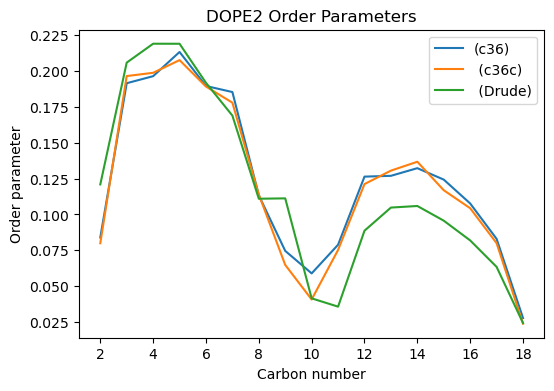

In [44]:
def load_and_plot(ax, folders, filenames, labels, title):
    """Load data from files in multiple folders, calculate averages, and plot."""
    for folder, label in zip(folders, labels):
        data = []
        for filename in filenames:
            data.append(np.loadtxt(f'{folder}/{filename}_bottom.dat'))
            data.append(np.loadtxt(f'{folder}/{filename}_top.dat'))
        avg_data = np.mean(data, axis=0)
        ax.plot(avg_data[:, 0], avg_data[:, 1], label=label)
    ax.set_title(title)
    ax.set_xlabel('Carbon number')
    ax.set_ylabel('Order parameter')
    ax.legend()

fig, ax = plt.subplots(figsize=(6, 4))
folders = ['c36', 'c36c','drude']
filenames = ['DOPE2', 'DOPE2','DOPE2']
labels = ['(c36)', ' (c36c)', ' (Drude)']
load_and_plot(ax, folders, filenames, labels, 'DOPE2 Order Parameters')

plt.savefig('DOPE2_ranges.png', dpi=300)
plt.show()